In [2]:
import collections
import datetime
import gzip
import importlib
import inspect
import ipaddress
import itertools
import json
import os
import pathlib
import pickle
import random
import re
import subprocess
import sys
import time
import timeit
import warnings

import numpy as np
import pandas as pd
import scipy.stats

from sklearn import cluster as sklearn_cluster
from sklearn import metrics as sklearn_metrics
from sklearn import model_selection as sklearn_model_selection
from sklearn import neighbors as sklearn_neighbors
from sklearn import preprocessing as sklearn_preprocessing

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
ROOT_DIRPATH = '/content/drive/Shareddrives/Project - VNET/Experiments/Clustering of Network Nodes'
DATA_DIRPATH = os.path.join(ROOT_DIRPATH, '2023-01-12')

RANDOM_STATE = 42

In [4]:
pd.set_option('display.max_columns', None)

In [15]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Test bed

## Test set of hyperparameters

In [6]:
def get_params(params, estimator_name, estimator_class):
    estimator_params_prefix = estimator_name + '__'
    estimator_signature_params = inspect.signature(estimator_class).parameters
    estimator_params = {
        name[len(estimator_params_prefix):]: value
        for name, value in params.items()
        if (name.startswith(estimator_params_prefix)
            and name[len(estimator_params_prefix):] in estimator_signature_params)
    }

    if 'random_state' in estimator_signature_params and 'random_state' in params:
        estimator_params['random_state'] = params['random_state']

    return estimator_params

In [7]:
params = {
    'feature_set': 'all',
    'clustering_method': 'sklearn_cluster.KMeans',
    'clustering_method__n_clusters': 10,
    'clustering_method__init': 'k-means++',
    'feature_sets_and_scalers': {'all': 'sklearn.preprocessing.MinMaxScaler'},
    'feature_scaler': 'sklearn_preprocessing.MinMaxScaler',
    'feature_scaler__n_quantiles': 1000,
    'feature_scaler__output_distribution': 'uniform',
    'random_state': 42,
}

# Loading common data

In [8]:
def load_df(filepath, csv_sep='|'):
    if filepath.endswith('.gz'):
        with gzip.open(filepath, 'rb') as f:
            df = pd.read_csv(f, sep=csv_sep)
    elif filepath.endswith('.parquet'):
        df = pd.read_parquet(filepath)
    elif filepath.endswith('.pkl-zip'):
        df = pd.read_pickle(filepath, compression='zip')
    elif filepath.endswith('.csv'):
        df = pd.read_csv(filepath, sep=csv_sep)
    else:
        df = pd.read_pickle(filepath)

    return df


def load_module_and_obj(obj_full_name):
    module_path, _, obj_name = obj_full_name.rpartition('.')
    module = importlib.import_module(module_path)

    return module, getattr(module, obj_name)


class _IPCategories:

    def __init__(self, df_ip_categories, max_prefixlen_diff_for_subnet_expansion=5):
        self.ip_categories = df_ip_categories.drop_duplicates(ignore_index=True).copy()
        self.max_prefixlen_diff_for_subnet_expansion = max_prefixlen_diff_for_subnet_expansion

        self.ip_categories['host_or_subnet'] = 'host'
        self.ip_categories.loc[
            self.ip_categories['ip'].str.contains('/', regex=False), 'host_or_subnet'
        ] = 'subnet'

        self.ip_categories['ip_obj'] = None

        host_cond = self.ip_categories['host_or_subnet'] == 'host'
        subnet_cond = self.ip_categories['host_or_subnet'] == 'subnet'
        self.ip_categories.loc[host_cond, 'ip_obj'] = (
            self.ip_categories.loc[host_cond, 'ip'].apply(ipaddress.ip_address))
        self.ip_categories.loc[subnet_cond, 'ip_obj'] = (
            self.ip_categories.loc[subnet_cond, 'ip'].apply(ipaddress.ip_network))

        self.ip_categories['version'] = self.ip_categories['ip_obj'].apply(self._get_ip_version)

        self.ip_categories = self._expand_subnets_to_ips(self.ip_categories)

        # Cannot reuse host_cond or subnet_cond, new rows have been added by now
        ip_addresses = self.ip_categories.loc[
            self.ip_categories['host_or_subnet'] == 'host', 'ip_obj'].tolist()
        ip_networks = self.ip_categories.loc[
            self.ip_categories['host_or_subnet'] == 'subnet', 'ip_obj'].tolist()

        self.ipv4_set = set([
            ip_address for ip_address in ip_addresses
            if isinstance(ip_address, ipaddress.IPv4Address)])
        self.ipv6_set = set([
            ip_address for ip_address in ip_addresses
            if isinstance(ip_address, ipaddress.IPv6Address)])
        self.ip_set = self.ipv4_set | self.ipv6_set

        self.ipv4_networks = [
            ip_network for ip_network in ip_networks
            if isinstance(ip_network, ipaddress.IPv4Network)]
        self.ipv6_networks = [
            ip_network for ip_network in ip_networks
            if isinstance(ip_network, ipaddress.IPv6Network)]
        self.ip_networks = self.ipv4_networks + self.ipv6_networks

    @staticmethod
    def _get_ip_version(ip_obj):
        if isinstance(ip_obj, ipaddress.IPv4Address) or isinstance(ip_obj, ipaddress.IPv4Network):
            return 4
        else:
            return 6

    def _expand_subnets_to_ips(self, df_ip_categories):
        return pd.concat(
            df_ip_categories.apply(self._expand_subnets_to_ips_per_row, axis=1).tolist(),
            ignore_index=True)

    def _expand_subnets_to_ips_per_row(self, row):
        if row['version'] not in [4, 6]:
            raise ValueError('invalid IP address version, must be 4 or 6')

        should_expand = False

        if row['host_or_subnet'] == 'subnet':
            if row['version'] == 4:
                max_prefixlen = 32
            else:
                max_prefixlen = 128

            if max_prefixlen - row['ip_obj'].prefixlen <= self.max_prefixlen_diff_for_subnet_expansion:
                should_expand = True

        if should_expand:
            new_ips = [
                pd.Series([str(new_ip), row['type'], 'host', new_ip, row['version']], index=row.index)
                for new_ip in row['ip_obj']
            ]
            return pd.DataFrame(new_ips, columns=row.index.tolist())
        else:
            return row.to_frame().T


def load_ip_categories(ip_categories_filepaths):
    if isinstance(ip_categories_filepaths, str):
        ip_categories_filepaths = [ip_categories_filepaths]

    df_ip_categories = pd.concat([
        pd.read_csv(filepath) for filepath in ip_categories_filepaths
    ]).reset_index(drop=True)

    return _IPCategories(df_ip_categories)

In [9]:
def load_features_and_labels(features_filepath, labels_filepath, ip_categories, remove_unknown_ips=True):
    df_features = load_df(features_filepath)

    df_labels = load_df(labels_filepath)
    df_labels['ip_address_obj'] = df_labels['ip_address'].apply(ipaddress.ip_address)
    df_labels = df_labels[['ip_address', 'ip_address_obj', 'category']].copy()

    if remove_unknown_ips:
        df_labels = df_labels[df_labels['category'] != 'Unknown'].reset_index(drop=True)
        df_features = df_features.iloc[df_labels.index].copy()

    return df_features, df_labels

In [16]:
ip_categories = load_ip_categories([
    os.path.join(ROOT_DIRPATH, 'VNET_IP_list', 'categories.csv'),
    os.path.join(ROOT_DIRPATH, 'VNET_IP_list', 'prefixes_routed_to_digitalis_ipv4.csv'),
    os.path.join(ROOT_DIRPATH, 'VNET_IP_list', 'prefixes_routed_to_digitalis_ipv6.csv'),
])

df_ip_categories = ip_categories.ip_categories

In [17]:
df_ip_categories

,ip,type,host_or_subnet,ip_obj,version
0,217.73.22.16,NET,host,217.73.22.16,4
1,81.89.53.237,NET,host,81.89.53.237,4
2,46.229.224.222,SH,host,46.229.224.222,4
3,109.74.146.55,SH,host,109.74.146.55,4
4,81.89.48.46,SH,host,81.89.48.46,4
...,...,...,...,...,...
23405,2a01:390:1::a7,SH,host,2a01:390:1::a7,6
23406,2a01:390:1::cafe,SH,host,2a01:390:1::cafe,6
23407,2a01:390:1::caff,SH,host,2a01:390:1::caff,6
23408,2a01:390:1:7::cafe,SH,host,2a01:390:1:7::cafe,6


# Interpreting clustering results

## Common functions

In [18]:
def load_clustering_results(filepath):
    with open(filepath, 'rb') as f:
        results = pickle.load(f)

    df_results = pd.DataFrame.from_records(results)

    # Allow grouping by feature sets
    if 'feature_set' in df_results.columns:
        df_results = df_results.rename(columns={'feature_set': 'feature_sets'})
    
    if 'feature_sets' in df_results.columns:
        df_results['feature_sets'] = df_results['feature_sets'].apply(lambda x: x if isinstance(x, str) else tuple(x))
    
    if 'feature_sets_and_scalers' in df_results.columns:
        df_results['feature_sets_and_scalers'] = df_results['feature_sets_and_scalers'].apply(lambda x: tuple(x.items()))
    
    if 'cluster_counts' in df_results.columns:
      df_results['cluster_count_entropy'] = df_results['cluster_counts'].apply(lambda x: scipy.stats.entropy(list(x.values())))

    return df_results

## *k*-means, scenario 1

In [19]:
df_results = load_clustering_results(os.path.join(DATA_DIRPATH, 'results', 'k_means_scenario_1.pkl'))

In [20]:
df_results.sort_values(by='metric__homogeneity', ascending=False)

,clustering_method,clustering_method__init,clustering_method__max_iter,clustering_method__n_clusters,clustering_method__n_init,feature_scaler__n_quantiles,feature_scaler__output_distribution,feature_sets,feature_sets_and_scalers,random_state,metric__homogeneity,metric__completeness,metric__v_measure,model__cluster_centers,model__inertia,model__labels,model__n_features_in,model__n_iter,cluster_counts,cluster_counts_per_category,cluster_labels,date,num_samples,cluster_count_entropy
14962,sklearn.cluster.KMeans,random,1000,15,1,1000,uniform,"(num_bytes_per_hour, in_out_bytes_ratio)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",142,0.323696,0.123257,0.178533,"[[6.08980571034166e-05, 5.2497333980656155e-05...",57.425850,"[0, 7, 7, 7, 7, 11, 8, 0, 9, 1, 1, 0, 0, 7, 11...",49,75,"{0: 9292, 12: 805, 7: 719, 10: 405, 3: 263, 11...","{('SH', 0): 8846, ('SH', 12): 696, ('SH', 7): ...","[0, 7, 7, 7, 7, 11, 8, 0, 9, 1, 1, 0, 0, 7, 11...",2023-01-16_14-18,11914,0.926692
9922,sklearn.cluster.KMeans,random,100,15,1,1000,uniform,"(num_bytes_per_hour, in_out_bytes_ratio)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",142,0.323696,0.123257,0.178533,"[[6.08980571034166e-05, 5.2497333980656155e-05...",57.425850,"[0, 7, 7, 7, 7, 11, 8, 0, 9, 1, 1, 0, 0, 7, 11...",49,75,"{0: 9292, 12: 805, 7: 719, 10: 405, 3: 263, 11...","{('SH', 0): 8846, ('SH', 12): 696, ('SH', 7): ...","[0, 7, 7, 7, 7, 11, 8, 0, 9, 1, 1, 0, 0, 7, 11...",2023-01-16_14-15,11914,0.926692
12442,sklearn.cluster.KMeans,random,300,15,1,1000,uniform,"(num_bytes_per_hour, in_out_bytes_ratio)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",142,0.323696,0.123257,0.178533,"[[6.08980571034166e-05, 5.2497333980656155e-05...",57.425850,"[0, 7, 7, 7, 7, 11, 8, 0, 9, 1, 1, 0, 0, 7, 11...",49,75,"{0: 9292, 12: 805, 7: 719, 10: 405, 3: 263, 11...","{('SH', 0): 8846, ('SH', 12): 696, ('SH', 7): ...","[0, 7, 7, 7, 7, 11, 8, 0, 9, 1, 1, 0, 0, 7, 11...",2023-01-16_14-16,11914,0.926692
9923,sklearn.cluster.KMeans,random,100,15,1,1000,uniform,"(num_bytes_per_hour, in_out_bytes_ratio)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",342,0.306989,0.144620,0.196616,"[[0.01204916007790389, 0.011135685403486946, 0...",56.868634,"[13, 13, 13, 13, 13, 0, 11, 13, 11, 8, 8, 13, ...",49,89,"{13: 9880, 6: 869, 5: 407, 12: 269, 0: 219, 1:...","{('SH', 13): 9320, ('SH', 6): 740, ('NET', 13)...","[13, 13, 13, 13, 13, 0, 11, 13, 11, 8, 8, 13, ...",2023-01-16_14-15,11914,0.749038
9983,sklearn.cluster.KMeans,random,100,15,10,1000,uniform,"(num_bytes_per_hour, in_out_bytes_ratio)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",342,0.306989,0.144620,0.196616,"[[0.01204916007790389, 0.011135685403486946, 0...",56.868634,"[13, 13, 13, 13, 13, 0, 11, 13, 11, 8, 8, 13, ...",49,89,"{13: 9880, 6: 869, 5: 407, 12: 269, 0: 219, 1:...","{('SH', 13): 9320, ('SH', 6): 740, ('NET', 13)...","[13, 13, 13, 13, 13, 0, 11, 13, 11, 8, 8, 13, ...",2023-01-16_14-15,11914,0.749038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,sklearn.cluster.KMeans,k-means++,100,2,1,1000,uniform,"(num_bytes_per_hour,)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",42,0.000543,0.016139,0.001050,"[[0.001295483026606347, 0.001294685183129793, ...",147.136901,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48,6,"{0: 11895, 1: 19}","{('SH', 0): 10548, ('NET', 0): 1347, ('SH', 1)...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2023-01-16_14-03,11914,0.011865
2541,sklearn.cluster.KMeans,k-means++,300,2,1,1000,uniform,"(num_bytes_per_hour, in_out_bytes_ratio)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",42,0.000543,0.016139,0.001050,"[[0.001295483026606347, 0.001294685183129793, ...",179.178943,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",49,6,"{0: 11895, 1: 19}","{('SH', 0): 10548, ('NET', 0): 1347, ('SH', 1)...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2023-01-16_14-06,11914,0.011865
23,sklearn.cluster.KMeans,k-means++,100,2,1,1000,uniform,

In [21]:
df_results.sort_values(by='model__inertia', ascending=True)

,clustering_method,clustering_method__init,clustering_method__max_iter,clustering_method__n_clusters,clustering_method__n_init,feature_scaler__n_quantiles,feature_scaler__output_distribution,feature_sets,feature_sets_and_scalers,random_state,metric__homogeneity,metric__completeness,metric__v_measure,model__cluster_centers,model__inertia,model__labels,model__n_features_in,model__n_iter,cluster_counts,cluster_counts_per_category,cluster_labels,date,num_samples,cluster_count_entropy
2416,sklearn.cluster.KMeans,k-means++,100,15,10,1000,uniform,"(num_bytes_per_hour,)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",142,0.00354,0.010424,0.005285,"[[0.0003087495596915777, 0.0002712327060443607...",22.957320,"[0, 0, 0, 0, 0, 0, 8, 0, 9, 2, 2, 0, 0, 0, 0, ...",48,11,"{0: 11692, 8: 129, 9: 34, 2: 21, 13: 16, 1: 5,...","{('SH', 0): 10351, ('NET', 0): 1341, ('SH', 8)...","[0, 0, 0, 0, 0, 0, 8, 0, 9, 2, 2, 0, 0, 0, 0, ...",2023-01-16_14-06,11914,0.119832
7516,sklearn.cluster.KMeans,k-means++,1000,15,20,1000,uniform,"(num_bytes_per_hour,)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",142,0.00354,0.010424,0.005285,"[[0.00030874955969157724, 0.000271232706044360...",22.957320,"[0, 0, 0, 0, 0, 0, 8, 0, 9, 2, 2, 0, 0, 0, 0, ...",48,11,"{0: 11692, 8: 129, 9: 34, 2: 21, 13: 16, 1: 5,...","{('SH', 0): 10351, ('NET', 0): 1341, ('SH', 8)...","[0, 0, 0, 0, 0, 0, 8, 0, 9, 2, 2, 0, 0, 0, 0, ...",2023-01-16_14-13,11914,0.119832
2476,sklearn.cluster.KMeans,k-means++,100,15,20,1000,uniform,"(num_bytes_per_hour,)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",142,0.00354,0.010424,0.005285,"[[0.00030874955969157724, 0.000271232706044360...",22.957320,"[0, 0, 0, 0, 0, 0, 8, 0, 9, 2, 2, 0, 0, 0, 0, ...",48,11,"{0: 11692, 8: 129, 9: 34, 2: 21, 13: 16, 1: 5,...","{('SH', 0): 10351, ('NET', 0): 1341, ('SH', 8)...","[0, 0, 0, 0, 0, 0, 8, 0, 9, 2, 2, 0, 0, 0, 0, ...",2023-01-16_14-06,11914,0.119832
7456,sklearn.cluster.KMeans,k-means++,1000,15,10,1000,uniform,"(num_bytes_per_hour,)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",142,0.00354,0.010424,0.005285,"[[0.0003087495596915777, 0.0002712327060443607...",22.957320,"[0, 0, 0, 0, 0, 0, 8, 0, 9, 2, 2, 0, 0, 0, 0, ...",48,11,"{0: 11692, 8: 129, 9: 34, 2: 21, 13: 16, 1: 5,...","{('SH', 0): 10351, ('NET', 0): 1341, ('SH', 8)...","[0, 0, 0, 0, 0, 0, 8, 0, 9, 2, 2, 0, 0, 0, 0, ...",2023-01-16_14-13,11914,0.119832
4996,sklearn.cluster.KMeans,k-means++,300,15,20,1000,uniform,"(num_bytes_per_hour,)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",142,0.00354,0.010424,0.005285,"[[0.0003087495596915777, 0.0002712327060443607...",22.957320,"[0, 0, 0, 0, 0, 0, 8, 0, 9, 2, 2, 0, 0, 0, 0, ...",48,11,"{0: 11692, 8: 129, 9: 34, 2: 21, 13: 16, 1: 5,...","{('SH', 0): 10351, ('NET', 0): 1341, ('SH', 8)...","[0, 0, 0, 0, 0, 0, 8, 0, 9, 2, 2, 0, 0, 0, 0, ...",2023-01-16_14-09,11914,0.119832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10083,sklearn.cluster.KMeans,random,300,2,1,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Qu...",42,0.00261,0.001345,0.001775,"[[0.6860931355879296, 0.7227849502667132, 0.61...",61841.781602,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",82,5,"{1: 6727, 0: 5187}","{('SH', 1): 6047, ('SH', 0): 4520, ('NET', 1):...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2023-01-16_14-15,11914,0.684770
5,sklearn.cluster.KMeans,k-means++,100,2,1,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Qu...",342,0.00261,0.001345,0.001775,"[[0.6860931355879296, 0.7227849502667132, 0.61...",61841.781602,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",82,9,"{1: 6727, 0: 5187}","{('SH', 1): 6047, ('SH', 0): 4520, ('NET', 1):...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2023-01-16_14-03,11914,0.684770
5045,sklearn.cluster.KMeans,k-means++,1000,2,1,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Qu...",342,0.00261,0.001345,0.001775,"[[0.6860931355879296, 0.7227849502667132, 0.61...

In [22]:
df_results.sort_values(by='cluster_count_entropy', ascending=False)

,clustering_method,clustering_method__init,clustering_method__max_iter,clustering_method__n_clusters,clustering_method__n_init,feature_scaler__n_quantiles,feature_scaler__output_distribution,feature_sets,feature_sets_and_scalers,random_state,metric__homogeneity,metric__completeness,metric__v_measure,model__cluster_centers,model__inertia,model__labels,model__n_features_in,model__n_iter,cluster_counts,cluster_counts_per_category,cluster_labels,date,num_samples,cluster_count_entropy
14943,sklearn.cluster.KMeans,random,1000,15,1,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Qu...",42,0.167745,0.022028,0.038943,"[[0.482287356405353, 0.44327769534320005, 0.21...",29795.400884,"[5, 11, 9, 14, 9, 5, 9, 14, 9, 5, 5, 14, 5, 5,...",82,53,"{8: 1016, 6: 1005, 10: 930, 5: 920, 2: 908, 12...","{('SH', 6): 993, ('SH', 8): 982, ('SH', 2): 89...","[5, 11, 9, 14, 9, 5, 9, 14, 9, 5, 5, 14, 5, 5,...",2023-01-16_14-18,11914,2.687051
12423,sklearn.cluster.KMeans,random,300,15,1,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Qu...",42,0.167745,0.022028,0.038943,"[[0.482287356405353, 0.44327769534320005, 0.21...",29795.400884,"[5, 11, 9, 14, 9, 5, 9, 14, 9, 5, 5, 14, 5, 5,...",82,53,"{8: 1016, 6: 1005, 10: 930, 5: 920, 2: 908, 12...","{('SH', 6): 993, ('SH', 8): 982, ('SH', 2): 89...","[5, 11, 9, 14, 9, 5, 9, 14, 9, 5, 5, 14, 5, 5,...",2023-01-16_14-16,11914,2.687051
9903,sklearn.cluster.KMeans,random,100,15,1,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Qu...",42,0.167745,0.022028,0.038943,"[[0.482287356405353, 0.44327769534320005, 0.21...",29795.400884,"[5, 11, 9, 14, 9, 5, 9, 14, 9, 5, 5, 14, 5, 5,...",82,53,"{8: 1016, 6: 1005, 10: 930, 5: 920, 2: 908, 12...","{('SH', 6): 993, ('SH', 8): 982, ('SH', 2): 89...","[5, 11, 9, 14, 9, 5, 9, 14, 9, 5, 5, 14, 5, 5,...",2023-01-16_14-15,11914,2.687051
9948,sklearn.cluster.KMeans,random,100,15,1,1000,uniform,"(port_probability, num_unique_tuples)","((port_probability, sklearn.preprocessing.MinM...",42,0.138125,0.018298,0.032316,"[[0.05242800687578533, 0.05242930297732523, 0....",3238.218155,"[11, 14, 0, 5, 11, 9, 11, 3, 11, 14, 5, 5, 5, ...",31,33,"{9: 1270, 2: 1170, 1: 1001, 6: 912, 3: 899, 5:...","{('SH', 9): 1208, ('SH', 2): 1115, ('SH', 6): ...","[11, 14, 0, 5, 11, 9, 11, 3, 11, 14, 5, 5, 5, ...",2023-01-16_14-15,11914,2.663609
12468,sklearn.cluster.KMeans,random,300,15,1,1000,uniform,"(port_probability, num_unique_tuples)","((port_probability, sklearn.preprocessing.MinM...",42,0.138125,0.018298,0.032316,"[[0.05242800687578533, 0.05242930297732523, 0....",3238.218155,"[11, 14, 0, 5, 11, 9, 11, 3, 11, 14, 5, 5, 5, ...",31,33,"{9: 1270, 2: 1170, 1: 1001, 6: 912, 3: 899, 5:...","{('SH', 9): 1208, ('SH', 2): 1115, ('SH', 6): ...","[11, 14, 0, 5, 11, 9, 11, 3, 11, 14, 5, 5, 5, ...",2023-01-16_14-16,11914,2.663609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,sklearn.cluster.KMeans,k-means++,100,2,20,1000,uniform,"(num_bytes_per_hour,)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",42,0.000543,0.016139,0.001050,"[[0.001295483026606347, 0.001294685183129793, ...",147.136901,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48,6,"{0: 11895, 1: 19}","{('SH', 0): 10548, ('NET', 0): 1347, ('SH', 1)...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2023-01-16_14-03,11914,0.011865
15,sklearn.cluster.KMeans,k-means++,100,2,1,1000,uniform,"(num_bytes_per_hour,)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",42,0.000543,0.016139,0.001050,"[[0.001295483026606347, 0.001294685183129793, ...",147.136901,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48,6,"{0: 11895, 1: 19}","{('SH', 0): 10548, ('NET', 0): 1347, ('SH', 1)...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2023-01-16_14-03,11914,0.011865
2535,sklearn.cluster.KMeans,k-means++,300,2,1,1000,uniform,"(num_bytes_per_hour,)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",42,0.000543,0.016139,0.001050,"[[0.001295483026606347, 0

## Assessing stability of results via different random states

In [23]:
clustering_method_params = [col for col in df_results.columns if col.startswith('clustering_method')]
feature_scaler_params = [col for col in df_results.columns if col.startswith('feature_scaler')]

groupby_cols = [
    *clustering_method_params,
    *feature_scaler_params,
    'feature_sets',
    'feature_sets_and_scalers',
]
metric_cols = [
    'random_state',
    'metric__homogeneity', 'metric__completeness', 'metric__v_measure',
    'model__inertia', 'model__n_features_in', 'model__n_iter',
    'cluster_count_entropy',
]

results_grouped_per_random_state = df_results[[*groupby_cols, *metric_cols]].groupby(groupby_cols).agg(['min', 'max', 'std'])
results_grouped_per_random_state

random_state  \
                                                                                                                                                                                                                                                                                                        min   
clustering_method      clustering_method__init clustering_method__max_iter clustering_method__n_clusters clustering_method__n_init feature_scaler__n_quantiles feature_scaler__output_distribution feature_sets                             feature_sets_and_scalers                                          
sklearn.cluster.KMeans k-means++               100                         2                             1                         1000                        uniform                             (num_bytes_per_hour,)                    ((num_bytes_per_hour, sklearn.preprocessing.Min...           42   
                                                                                                                                                                                                                                            ((num_bytes_per_hour, sklearn.preprocessing.Qua...           42   
                                                                                                                                                                                                   (num_bytes_per_hour, in_out_bytes_ratio) ((num_bytes_per_hour, sklearn.preprocessing.Min...           42   
                                                                                                                                                                                                                                            ((num_bytes_per_hour, sklearn.preprocessing.Qua...           42   
                                                                                                                                                                                                                                            ((num_bytes_per_hour, sklearn.preprocessing.Qua...           42   
...                                                                                                                                                                                                                                                                                                     ...   
                       random                  1000                        15                            20                        1000                        uniform                             all                                      ((num_bytes_per_hour, sklearn.preprocessing.Min...           42   
                                                                                                                                                                                                                                            ((num_bytes_per_hour, sklearn.preprocessing.Min...           42   
                                                                                                                                                                                                                                            ((num_bytes_per_hour, sklearn.preprocessing.Qua...           42   
                                                                                                                                                                                                                                            ((num_bytes_per_hour, sklearn.preprocessing.Qua...           42   
                                                                                                                                                                                                                                            ((num_bytes_per_hour, sklearn.preprocessing.Qua...           42   

                                            

## Sorted by inertia, any feature set

In [24]:
df_results.loc[
    ((df_results['clustering_method__n_clusters'] >= 4)
    & (df_results['clustering_method__n_clusters'] <= 9))
].sort_values(by='model__inertia', ascending=True).iloc[:50].drop_duplicates(
    subset=['clustering_method__n_clusters', 'feature_sets', 'model__inertia', 'metric__homogeneity', 'cluster_count_entropy'],
)

,clustering_method,clustering_method__init,clustering_method__max_iter,clustering_method__n_clusters,clustering_method__n_init,feature_scaler__n_quantiles,feature_scaler__output_distribution,feature_sets,feature_sets_and_scalers,random_state,metric__homogeneity,metric__completeness,metric__v_measure,model__cluster_centers,model__inertia,model__labels,model__n_features_in,model__n_iter,cluster_counts,cluster_counts_per_category,cluster_labels,date,num_samples,cluster_count_entropy
6436,sklearn.cluster.KMeans,k-means++,1000,9,20,1000,uniform,"(num_bytes_per_hour,)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",142,0.002395,0.011831,0.003984,"[[0.0004537268360725985, 0.0003888008311475396...",36.695437,"[0, 0, 0, 0, 0, 0, 8, 0, 8, 1, 1, 0, 0, 0, 0, ...",48,5,"{0: 11789, 8: 71, 1: 32, 4: 9, 2: 3, 5: 3, 3: ...","{('SH', 0): 10444, ('NET', 0): 1345, ('SH', 8)...","[0, 0, 0, 0, 0, 0, 8, 0, 8, 1, 1, 0, 0, 0, 0, ...",2023-01-16_14-11,11914,0.071430
3855,sklearn.cluster.KMeans,k-means++,300,9,10,1000,uniform,"(num_bytes_per_hour,)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",42,0.002395,0.011831,0.003984,"[[0.0004537268360725985, 0.0003888008311475396...",36.695437,"[0, 0, 0, 0, 0, 0, 2, 0, 2, 6, 6, 0, 0, 0, 0, ...",48,5,"{0: 11789, 2: 71, 6: 32, 1: 9, 5: 3, 7: 3, 4: ...","{('SH', 0): 10444, ('NET', 0): 1345, ('SH', 2)...","[0, 0, 0, 0, 0, 0, 2, 0, 2, 6, 6, 0, 0, 0, 0, ...",2023-01-16_14-07,11914,0.071430
6315,sklearn.cluster.KMeans,k-means++,1000,9,1,1000,uniform,"(num_bytes_per_hour,)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",42,0.002273,0.011566,0.003799,"[[0.0004633512620274762, 0.0003955566627599938...",36.750343,"[0, 0, 0, 0, 0, 0, 4, 0, 4, 8, 8, 0, 0, 0, 0, ...",48,8,"{0: 11793, 4: 72, 8: 27, 2: 9, 1: 3, 6: 3, 5: ...","{('SH', 0): 10448, ('NET', 0): 1345, ('SH', 4)...","[0, 0, 0, 0, 0, 0, 4, 0, 4, 8, 8, 0, 0, 0, 0, ...",2023-01-16_14-11,11914,0.069344
3857,sklearn.cluster.KMeans,k-means++,300,9,10,1000,uniform,"(num_bytes_per_hour,)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",342,0.002273,0.011542,0.003798,"[[0.0004633512620274762, 0.0003955566627599938...",37.161389,"[0, 0, 0, 0, 0, 0, 6, 0, 6, 3, 3, 0, 0, 0, 0, ...",48,10,"{0: 11793, 6: 72, 3: 27, 4: 8, 2: 3, 8: 3, 5: ...","{('SH', 0): 10448, ('NET', 0): 1345, ('SH', 6)...","[0, 0, 0, 0, 0, 0, 6, 0, 6, 3, 3, 0, 0, 0, 0, ...",2023-01-16_14-07,11914,0.069491
6377,sklearn.cluster.KMeans,k-means++,1000,9,10,1000,uniform,"(num_bytes_per_hour,)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",342,0.002273,0.011542,0.003798,"[[0.0004633512620274762, 0.0003955566627599938...",37.161389,"[0, 0, 0, 0, 0, 0, 6, 0, 6, 3, 3, 0, 0, 0, 0, ...",48,10,"{0: 11793, 6: 72, 3: 27, 4: 8, 2: 3, 8: 3, 5: ...","{('SH', 0): 10448, ('NET', 0): 1345, ('SH', 6)...","[0, 0, 0, 0, 0, 0, 6, 0, 6, 3, 3, 0, 0, 0, 0, ...",2023-01-16_14-11,11914,0.069491
6317,sklearn.cluster.KMeans,k-means++,1000,9,1,1000,uniform,"(num_bytes_per_hour,)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",342,0.003128,0.010580,0.004829,"[[0.00032394655838000443, 0.000284923299714331...",38.916280,"[0, 0, 0, 0, 0, 0, 8, 0, 8, 1, 1, 0, 0, 0, 0, ...",48,6,"{0: 11717, 8: 123, 7: 37, 1: 15, 3: 9, 4: 4, 2...","{('SH', 0): 10375, ('NET', 0): 1342, ('SH', 8)...","[0, 0, 0, 0, 0, 0, 8, 0, 8, 1, 1, 0, 0, 0, 0, ...",2023-01-16_14-11,11914,0.104328
3797,sklearn.cluster.KMeans,k-means++,300,9,1,1000,uniform,"(num_bytes_per_hour,)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",342,0.003128,0.010580,0.004829,"[[0.0003239465583800042, 0.0002849232997143311...",38.916280,"[0, 0, 0, 0, 0, 0, 8, 0, 8, 1, 1, 0, 0, 0, 0, ...",48,6,"{0: 11717, 8: 123, 7: 37, 1: 15, 3: 9, 4: 4, 2...","{('SH', 0): 10375, ('NET', 0): 1342, ('SH', 8)...","[0, 0, 0, 0, 0, 0, 8, 0, 8, 1, 1, 0, 0, 0, 0, ...",2023-01-16_14-07,11914,0.104328
1216,sklearn.cluster.KMeans,k-means++,100,8,20,1000,uniform,"(num_bytes_per_hour,)","((num_bytes_per_hour, sklearn.preprocessing.Mi...",142,0.002373,0.011825,0.003953,"[[0.2890980775738593, 0.9352

## Sorted by inertia, all features

In [25]:
df_results.loc[
    ((df_results['clustering_method__n_clusters'] >= 4)
    & (df_results['clustering_method__n_clusters'] <= 9))
    & (df_results['feature_sets'] == 'all'),
].sort_values(by='model__inertia', ascending=True).iloc[:50].drop_duplicates(
    subset=['clustering_method__n_clusters', 'feature_sets', 'model__inertia', 'metric__homogeneity', 'cluster_count_entropy'],
)

,clustering_method,clustering_method__init,clustering_method__max_iter,clustering_method__n_clusters,clustering_method__n_init,feature_scaler__n_quantiles,feature_scaler__output_distribution,feature_sets,feature_sets_and_scalers,random_state,metric__homogeneity,metric__completeness,metric__v_measure,model__cluster_centers,model__inertia,model__labels,model__n_features_in,model__n_iter,cluster_counts,cluster_counts_per_category,cluster_labels,date,num_samples,cluster_count_entropy
1322,sklearn.cluster.KMeans,k-means++,100,9,10,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Mi...",342,0.054084,0.008962,0.015377,"[[0.46662256506502314, 0.4575849934234335, 0.5...",3276.235391,"[4, 7, 8, 8, 5, 1, 5, 7, 5, 8, 8, 8, 8, 6, 8, ...",82,15,"{6: 1933, 1: 1901, 2: 1642, 8: 1582, 7: 1367, ...","{('SH', 1): 1729, ('SH', 6): 1612, ('SH', 2): ...","[4, 7, 8, 8, 5, 1, 5, 7, 5, 8, 8, 8, 8, 6, 8, ...",2023-01-16_14-04,11914,2.129390
1321,sklearn.cluster.KMeans,k-means++,100,9,10,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Mi...",142,0.054084,0.008962,0.015377,"[[0.10098768002713318, 0.13188958676747514, 0....",3276.235391,"[8, 7, 3, 3, 6, 1, 6, 7, 6, 3, 3, 3, 3, 0, 3, ...",82,12,"{0: 1933, 1: 1901, 4: 1642, 3: 1582, 7: 1367, ...","{('SH', 1): 1729, ('SH', 0): 1612, ('SH', 4): ...","[8, 7, 3, 3, 6, 1, 6, 7, 6, 3, 3, 3, 3, 0, 3, ...",2023-01-16_14-04,11914,2.129390
3900,sklearn.cluster.KMeans,k-means++,300,9,20,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Mi...",42,0.054275,0.008992,0.015428,"[[0.41331133244974483, 0.5298954622947972, 0.0...",3276.245099,"[4, 5, 0, 0, 6, 7, 6, 5, 6, 0, 0, 0, 0, 3, 0, ...",82,14,"{3: 1933, 7: 1883, 2: 1642, 0: 1583, 5: 1384, ...","{('SH', 7): 1714, ('SH', 3): 1612, ('SH', 2): ...","[4, 5, 0, 0, 6, 7, 6, 5, 6, 0, 0, 0, 0, 3, 0, ...",2023-01-16_14-08,11914,2.129910
13980,sklearn.cluster.KMeans,random,1000,9,20,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Mi...",42,0.054334,0.009003,0.015447,"[[0.19795400609285269, 0.26318163138363426, 0....",3276.509821,"[8, 0, 6, 6, 5, 1, 5, 0, 5, 6, 6, 6, 6, 4, 6, ...",82,16,"{1: 1920, 4: 1912, 3: 1638, 6: 1586, 0: 1367, ...","{('SH', 1): 1746, ('SH', 4): 1592, ('SH', 3): ...","[8, 0, 6, 6, 5, 1, 5, 0, 5, 6, 6, 6, 6, 4, 6, ...",2023-01-16_14-17,11914,2.129582
11460,sklearn.cluster.KMeans,random,300,9,20,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Mi...",42,0.054334,0.009003,0.015447,"[[0.19795400609285269, 0.26318163138363426, 0....",3276.509821,"[8, 0, 6, 6, 5, 1, 5, 0, 5, 6, 6, 6, 6, 4, 6, ...",82,16,"{1: 1920, 4: 1912, 3: 1638, 6: 1586, 0: 1367, ...","{('SH', 1): 1746, ('SH', 4): 1592, ('SH', 3): ...","[8, 0, 6, 6, 5, 1, 5, 0, 5, 6, 6, 6, 6, 4, 6, ...",2023-01-16_14-16,11914,2.129582
3840,sklearn.cluster.KMeans,k-means++,300,9,10,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Mi...",42,0.061181,0.010264,0.017579,"[[0.3443209959214753, 0.22790205020628457, 0.0...",3279.773612,"[7, 8, 0, 6, 5, 2, 5, 8, 5, 6, 6, 6, 6, 6, 6, ...",82,16,"{2: 2242, 1: 1890, 4: 1635, 8: 1521, 3: 1468, ...","{('SH', 2): 2071, ('SH', 1): 1579, ('SH', 3): ...","[7, 8, 0, 6, 5, 2, 5, 8, 5, 6, 6, 6, 6, 6, 6, ...",2023-01-16_14-07,11914,2.103308
11462,sklearn.cluster.KMeans,random,300,9,20,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Mi...",342,0.056317,0.009288,0.015945,"[[0.5978852313930534, 0.5550942492322394, 0.13...",3288.167802,"[3, 0, 2, 2, 6, 0, 6, 7, 6, 2, 2, 2, 2, 4, 2, ...",82,22,"{4: 1942, 0: 1860, 5: 1637, 2: 1518, 7: 1342, ...","{('SH', 0): 1689, ('SH', 4): 1619, ('SH', 5): ...","[3, 0, 2, 2, 6, 0, 6, 7, 6, 2, 2, 2, 2, 4, 2, ...",2023-01-16_14-16,11914,2.139650
13982,sklearn.cluster.KMeans,random,1000,9,20,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Mi...",342,0.056317,0.009288,0.015945,"[[0.5978852313930534, 0.5550942492322394, 0.13...",3288.167802,"[3, 0, 2, 2, 6, 0, 6, 7, 6, 2, 2, 2, 2, 4, 2, ...",82,22,"{4: 1942, 0: 1860, 5: 1637, 2: 1518, 7: 1342, ...","{('S

## Sorted by inertia, no bytes-based features

In [26]:
df_results.loc[
    (df_results['clustering_method__n_clusters'] >= 4)
    & (df_results['clustering_method__n_clusters'] <= 9)
    & (df_results['feature_sets'] == ('port_probability', 'port_entropy', 'num_unique_tuples'))
].sort_values(by='model__inertia', ascending=True).iloc[:50].drop_duplicates(
    subset=['clustering_method__n_clusters', 'feature_sets', 'model__inertia', 'metric__homogeneity', 'cluster_count_entropy'],
)

,clustering_method,clustering_method__init,clustering_method__max_iter,clustering_method__n_clusters,clustering_method__n_init,feature_scaler__n_quantiles,feature_scaler__output_distribution,feature_sets,feature_sets_and_scalers,random_state,metric__homogeneity,metric__completeness,metric__v_measure,model__cluster_centers,model__inertia,model__labels,model__n_features_in,model__n_iter,cluster_counts,cluster_counts_per_category,cluster_labels,date,num_samples,cluster_count_entropy
6472,sklearn.cluster.KMeans,k-means++,1000,9,20,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.MinMaxSc...",142,0.053932,0.008937,0.015334,"[[0.529071812280709, 0.5290816938459907, 0.025...",2948.625341,"[5, 2, 3, 3, 8, 7, 8, 2, 8, 7, 3, 3, 3, 1, 3, ...",33,19,"{1: 1935, 7: 1907, 6: 1638, 3: 1578, 2: 1367, ...","{('SH', 7): 1734, ('SH', 1): 1613, ('SH', 6): ...","[5, 2, 3, 3, 8, 7, 8, 2, 8, 7, 3, 3, 3, 1, 3, ...",2023-01-16_14-11,11914,2.129310
14031,sklearn.cluster.KMeans,random,1000,9,20,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.MinMaxSc...",42,0.054221,0.008984,0.015414,"[[0.007782071634435339, 0.007789436228416269, ...",2948.848830,"[8, 0, 6, 6, 5, 1, 5, 0, 5, 1, 6, 6, 6, 4, 6, ...",33,17,"{1: 1916, 4: 1912, 3: 1638, 6: 1588, 0: 1369, ...","{('SH', 1): 1743, ('SH', 4): 1592, ('SH', 3): ...","[8, 0, 6, 6, 5, 1, 5, 0, 5, 1, 6, 6, 6, 4, 6, ...",2023-01-16_14-17,11914,2.129671
8991,sklearn.cluster.KMeans,random,100,9,20,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.MinMaxSc...",42,0.054221,0.008984,0.015414,"[[0.007782071634435311, 0.007789436228416241, ...",2948.848830,"[8, 0, 6, 6, 5, 1, 5, 0, 5, 1, 6, 6, 6, 4, 6, ...",33,17,"{1: 1916, 4: 1912, 3: 1638, 6: 1588, 0: 1369, ...","{('SH', 1): 1743, ('SH', 4): 1592, ('SH', 3): ...","[8, 0, 6, 6, 5, 1, 5, 0, 5, 1, 6, 6, 6, 4, 6, ...",2023-01-16_14-14,11914,2.129671
3891,sklearn.cluster.KMeans,k-means++,300,9,10,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.MinMaxSc...",42,0.052548,0.008718,0.014955,"[[0.9788136020367109, 0.9788133074907538, 0.00...",2950.794943,"[6, 4, 1, 1, 5, 7, 5, 4, 5, 7, 1, 1, 1, 2, 1, ...",33,10,"{2: 1942, 7: 1916, 3: 1639, 1: 1616, 4: 1365, ...","{('SH', 7): 1742, ('SH', 2): 1616, ('SH', 3): ...","[6, 4, 1, 1, 5, 7, 5, 4, 5, 7, 1, 1, 1, 2, 1, ...",2023-01-16_14-08,11914,2.126829
1371,sklearn.cluster.KMeans,k-means++,100,9,10,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.MinMaxSc...",42,0.052548,0.008718,0.014955,"[[0.9788136020367109, 0.9788133074907539, 0.00...",2950.794943,"[6, 4, 1, 1, 5, 7, 5, 4, 5, 7, 1, 1, 1, 2, 1, ...",33,10,"{2: 1942, 7: 1916, 3: 1639, 1: 1616, 4: 1365, ...","{('SH', 7): 1742, ('SH', 2): 1616, ('SH', 3): ...","[6, 4, 1, 1, 5, 7, 5, 4, 5, 7, 1, 1, 1, 2, 1, ...",2023-01-16_14-04,11914,2.126829
6413,sklearn.cluster.KMeans,k-means++,1000,9,10,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.MinMaxSc...",342,0.052559,0.008720,0.014959,"[[0.9788136020367109, 0.9788133074907538, 0.00...",2950.795570,"[5, 7, 1, 1, 6, 4, 6, 7, 6, 4, 1, 1, 1, 2, 1, ...",33,13,"{2: 1942, 4: 1918, 3: 1639, 1: 1616, 7: 1363, ...","{('SH', 4): 1744, ('SH', 2): 1616, ('SH', 3): ...","[5, 7, 1, 1, 6, 4, 6, 7, 6, 4, 1, 1, 1, 2, 1, ...",2023-01-16_14-11,11914,2.126772
6473,sklearn.cluster.KMeans,k-means++,1000,9,20,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.MinMaxSc...",342,0.052559,0.008720,0.014959,"[[0.9788136020367109, 0.9788133074907539, 0.00...",2950.795570,"[5, 7, 1, 1, 6, 4, 6, 7, 6, 4, 1, 1, 1, 2, 1, ...",33,13,"{2: 1942, 4: 1918, 3: 1639, 1: 1616, 7: 1363, ...","{('SH', 4): 1744, ('SH', 2): 1616, ('SH', 3): ...","[5, 7, 1, 1, 6, 4, 6, 7, 6, 4, 1, 1, 1, 2, 1, ...",2023-01-16_14-11,

## Sorted by cluster count entropy, no bytes-based features

In [27]:
df_results.loc[
    (df_results['clustering_method__n_clusters'] >= 4)
    & (df_results['clustering_method__n_clusters'] <= 9)
    & (df_results['feature_sets'] == ('port_probability', 'port_entropy', 'num_unique_tuples'))
].sort_values(by='cluster_count_entropy', ascending=False).iloc[:50].drop_duplicates(
    subset=['clustering_method__n_clusters', 'feature_sets', 'model__inertia', 'metric__homogeneity', 'cluster_count_entropy'],
)

,clustering_method,clustering_method__init,clustering_method__max_iter,clustering_method__n_clusters,clustering_method__n_init,feature_scaler__n_quantiles,feature_scaler__output_distribution,feature_sets,feature_sets_and_scalers,random_state,metric__homogeneity,metric__completeness,metric__v_measure,model__cluster_centers,model__inertia,model__labels,model__n_features_in,model__n_iter,cluster_counts,cluster_counts_per_category,cluster_labels,date,num_samples,cluster_count_entropy
13914,sklearn.cluster.KMeans,random,1000,9,1,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.Quantile...",42,0.122292,0.020060,0.034466,"[[0.7339626968183393, 0.7392795928788751, 0.78...",17204.925966,"[5, 5, 4, 3, 4, 5, 4, 3, 4, 5, 5, 3, 5, 5, 5, ...",33,16,"{7: 2133, 1: 1638, 8: 1517, 6: 1500, 0: 1264, ...","{('SH', 7): 1863, ('SH', 6): 1455, ('SH', 8): ...","[5, 5, 4, 3, 4, 5, 4, 3, 4, 5, 5, 3, 5, 5, 5, ...",2023-01-16_14-17,11914,2.151199
3955,sklearn.cluster.KMeans,k-means++,300,9,20,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.Quantile...",142,0.120495,0.019894,0.034150,"[[0.9390527514487613, 0.9390589929094804, 0.02...",16693.750959,"[1, 1, 6, 8, 6, 1, 6, 8, 6, 1, 1, 8, 1, 1, 1, ...",33,41,"{4: 1918, 7: 1917, 3: 1725, 0: 1481, 5: 1240, ...","{('SH', 7): 1834, ('SH', 3): 1451, ('SH', 0): ...","[1, 1, 6, 8, 6, 1, 6, 8, 6, 1, 1, 8, 1, 1, 1, ...",2023-01-16_14-08,11914,2.137284
13975,sklearn.cluster.KMeans,random,1000,9,10,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.Quantile...",142,0.120591,0.019911,0.034178,"[[0.5465568139469563, 0.5546561294483812, 0.23...",16693.816258,"[1, 1, 6, 0, 6, 1, 6, 0, 6, 1, 1, 0, 1, 1, 1, ...",33,35,"{3: 1917, 7: 1917, 5: 1726, 2: 1481, 8: 1250, ...","{('SH', 3): 1834, ('SH', 5): 1452, ('SH', 2): ...","[1, 1, 6, 0, 6, 1, 6, 0, 6, 1, 1, 0, 1, 1, 1, ...",2023-01-16_14-17,11914,2.137179
6415,sklearn.cluster.KMeans,k-means++,1000,9,10,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.Quantile...",142,0.119510,0.019733,0.033873,"[[0.5479848581573028, 0.5560865979222823, 0.23...",16693.767588,"[5, 5, 7, 0, 7, 5, 7, 0, 7, 5, 5, 0, 5, 5, 5, ...",33,23,"{1: 1917, 2: 1913, 6: 1734, 4: 1482, 8: 1241, ...","{('SH', 1): 1834, ('SH', 6): 1455, ('SH', 4): ...","[5, 5, 7, 0, 7, 5, 7, 0, 7, 5, 5, 0, 5, 5, 5, ...",2023-01-16_14-11,11914,2.137071
1376,sklearn.cluster.KMeans,k-means++,100,9,10,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.Quantile...",342,0.133539,0.022055,0.037858,"[[0.05614707254589263, 0.05787462552340178, 0....",16871.644910,"[1, 4, 6, 3, 6, 1, 6, 3, 6, 1, 1, 3, 1, 4, 1, ...",33,11,"{8: 2173, 0: 1698, 2: 1667, 5: 1485, 1: 1245, ...","{('SH', 8): 2091, ('SH', 5): 1441, ('SH', 0): ...","[1, 4, 6, 3, 6, 1, 6, 3, 6, 1, 1, 3, 1, 4, 1, ...",2023-01-16_14-04,11914,2.136527
3896,sklearn.cluster.KMeans,k-means++,300,9,10,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.Quantile...",342,0.133539,0.022055,0.037858,"[[0.05614707254589263, 0.057874625523401835, 0...",16871.644910,"[1, 4, 6, 3, 6, 1, 6, 3, 6, 1, 1, 3, 1, 4, 1, ...",33,11,"{8: 2173, 0: 1698, 2: 1667, 5: 1485, 1: 1245, ...","{('SH', 8): 2091, ('SH', 5): 1441, ('SH', 0): ...","[1, 4, 6, 3, 6, 1, 6, 3, 6, 1, 1, 3, 1, 4, 1, ...",2023-01-16_14-08,11914,2.136527
1316,sklearn.cluster.KMeans,k-means++,100,9,1,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.Quantile...",342,0.109230,0.018043,0.030970,"[[0.5573525933082983, 0.5676974320805639, 0.26...",17196.812671,"[7, 7, 1, 0, 1, 7, 1, 0, 1, 7, 7, 0, 7, 7, 7, ...",33,24,"{7: 2303, 3: 1595, 6: 1513, 5: 1463, 8: 1455, ...","{('SH', 7): 2017, ('SH', 6): 1437, ('SH', 5): ...","[7, 7, 1, 0, 1, 7, 1, 0, 1, 7, 7, 0, 7, 7, 7, ...",2023-01-1

In [28]:
def get_good_result(df_results, clustering_method_params, feature_scaler_params, index, random_state=None):
    good_result_params = df_results.loc[
        index,
        [
            *clustering_method_params,
            *feature_scaler_params,
            'feature_sets',
            'feature_sets_and_scalers',
        ]
    ].to_dict()

    good_result_params.pop('clustering_method__n_clusters')

    if random_state is not None:
        good_result_params['random_state'] = random_state
    good_results = df_results[(df_results[good_result_params.keys()] == good_result_params.values()).all(axis=1)]

    return good_results

Stability of "good enough" results with regards to different random states:

In [29]:
get_good_result(df_results, clustering_method_params, feature_scaler_params, 1322)

,clustering_method,clustering_method__init,clustering_method__max_iter,clustering_method__n_clusters,clustering_method__n_init,feature_scaler__n_quantiles,feature_scaler__output_distribution,feature_sets,feature_sets_and_scalers,random_state,metric__homogeneity,metric__completeness,metric__v_measure,model__cluster_centers,model__inertia,model__labels,model__n_features_in,model__n_iter,cluster_counts,cluster_counts_per_category,cluster_labels,date,num_samples,cluster_count_entropy
60,sklearn.cluster.KMeans,k-means++,100,2,10,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Mi...",42,0.032945,0.017871,0.023172,"[[0.3457158371259082, 0.35080724722226836, 0.2...",8556.657717,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, ...",82,4,"{0: 7684, 1: 4230}","{('SH', 0): 7097, ('SH', 1): 3470, ('NET', 1):...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, ...",2023-01-16_14-03,11914,0.650514
61,sklearn.cluster.KMeans,k-means++,100,2,10,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Mi...",142,0.032945,0.017871,0.023172,"[[0.3457158371259082, 0.35080724722226836, 0.2...",8556.657717,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, ...",82,4,"{0: 7684, 1: 4230}","{('SH', 0): 7097, ('SH', 1): 3470, ('NET', 1):...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, ...",2023-01-16_14-03,11914,0.650514
62,sklearn.cluster.KMeans,k-means++,100,2,10,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Mi...",342,0.032945,0.017871,0.023172,"[[0.3457158371259082, 0.35080724722226836, 0.2...",8556.657717,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, ...",82,6,"{0: 7684, 1: 4230}","{('SH', 0): 7097, ('SH', 1): 3470, ('NET', 1):...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, ...",2023-01-16_14-03,11914,0.650514
240,sklearn.cluster.KMeans,k-means++,100,3,10,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Mi...",42,0.038980,0.014092,0.020700,"[[0.4036450866803624, 0.4144755193244568, 0.08...",6070.823872,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, ...",82,6,"{0: 6184, 1: 4145, 2: 1585}","{('SH', 0): 5620, ('SH', 1): 3410, ('SH', 2): ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, ...",2023-01-16_14-03,11914,0.976048
241,sklearn.cluster.KMeans,k-means++,100,3,10,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Mi...",142,0.038980,0.014092,0.020700,"[[0.12260168814499078, 0.11765117639584152, 0....",6070.824141,"[2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, ...",82,11,"{2: 6184, 1: 4145, 0: 1585}","{('SH', 2): 5620, ('SH', 1): 3410, ('SH', 0): ...","[2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, ...",2023-01-16_14-03,11914,0.976048
242,sklearn.cluster.KMeans,k-means++,100,3,10,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Mi...",342,0.038980,0.014092,0.020700,"[[0.4036450866803624, 0.4144755193244568, 0.08...",6070.823872,"[0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, ...",82,7,"{0: 6184, 2: 4145, 1: 1585}","{('SH', 0): 5620, ('SH', 2): 3410, ('SH', 1): ...","[0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, ...",2023-01-16_14-03,11914,0.976048
420,sklearn.cluster.KMeans,k-means++,100,4,10,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Mi...",42,0.045934,0.012760,0.019972,"[[0.12495876350738055, 0.11998246115674671, 0....",5296.673871,"[3, 1, 1, 2, 3, 1, 3, 1, 3, 1, 2, 2, 1, 2, 2, ...",82,12,"{1: 4659, 2: 4093, 0: 1594, 3: 1568}","{('SH', 1): 4147, ('SH', 2): 3374, ('SH', 0): ...","[3, 1, 1, 2, 3, 1, 3, 1, 3, 1, 2, 2, 1, 2, 2, ...",2023-01-16_14-03,11914,1.270233
421,sklearn.cluster.KMeans,k-means++,100,4,10,1000,uniform,all,"((num_bytes_per_hour, sklearn.preprocessing.Mi...",142,0.045934,0.012760,0.019972,"[[0.43680460372972907, 0.4517176159710334, 0.1...",5296.673871,"[3, 0, 0, 1, 3, 0, 3, 0, 3, 0, 1, 1, 0, 1, 1, ...",82,18,"{0: 4659, 1: 4093, 2: 1594, 3: 1568}","{('SH', 0): 4147, ('SH', 1): 3374, ('SH', 2): ...","[3, 0, 0, 1, 3, 0, 3, 0, 3, 0, 1, 1, 0, 1, 1, ...",2023-01-16_14-03,11914,1.270233
422,sklearn.cluster.KMeans,k-means++,100,4,10,1000,uniform,all,

In [30]:
get_good_result(df_results, clustering_method_params, feature_scaler_params, 6472)

,clustering_method,clustering_method__init,clustering_method__max_iter,clustering_method__n_clusters,clustering_method__n_init,feature_scaler__n_quantiles,feature_scaler__output_distribution,feature_sets,feature_sets_and_scalers,random_state,metric__homogeneity,metric__completeness,metric__v_measure,model__cluster_centers,model__inertia,model__labels,model__n_features_in,model__n_iter,cluster_counts,cluster_counts_per_category,cluster_labels,date,num_samples,cluster_count_entropy
5211,sklearn.cluster.KMeans,k-means++,1000,2,20,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.MinMaxSc...",42,0.032596,0.017687,0.022931,"[[0.25596211906729655, 0.25599345776574717, 0....",8224.081107,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, ...",33,5,"{0: 7688, 1: 4226}","{('SH', 0): 7099, ('SH', 1): 3468, ('NET', 1):...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, ...",2023-01-16_14-10,11914,0.650313
5212,sklearn.cluster.KMeans,k-means++,1000,2,20,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.MinMaxSc...",142,0.032596,0.017687,0.022931,"[[0.2559294966308368, 0.25596083125350405, 0.0...",8224.081332,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, ...",33,4,"{0: 7688, 1: 4226}","{('SH', 0): 7099, ('SH', 1): 3468, ('NET', 1):...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, ...",2023-01-16_14-10,11914,0.650313
5213,sklearn.cluster.KMeans,k-means++,1000,2,20,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.MinMaxSc...",342,0.032596,0.017687,0.022931,"[[0.011562401752670065, 0.011398464112480383, ...",8224.081107,"[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, ...",33,5,"{1: 7688, 0: 4226}","{('SH', 1): 7099, ('SH', 0): 3468, ('NET', 0):...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, ...",2023-01-16_14-10,11914,0.650313
5391,sklearn.cluster.KMeans,k-means++,1000,3,20,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.MinMaxSc...",42,0.038751,0.014009,0.020578,"[[0.08537742622684354, 0.0854160922640373, 0.0...",5738.304192,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, ...",33,7,"{0: 6182, 1: 4147, 2: 1585}","{('SH', 0): 5617, ('SH', 1): 3413, ('SH', 2): ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, ...",2023-01-16_14-10,11914,0.976115
5392,sklearn.cluster.KMeans,k-means++,1000,3,20,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.MinMaxSc...",142,0.038751,0.014009,0.020578,"[[0.08537742622684354, 0.0854160922640373, 0.0...",5738.304192,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, ...",33,10,"{0: 6182, 1: 4147, 2: 1585}","{('SH', 0): 5617, ('SH', 1): 3413, ('SH', 2): ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, ...",2023-01-16_14-10,11914,0.976115
5393,sklearn.cluster.KMeans,k-means++,1000,3,20,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.MinMaxSc...",342,0.038751,0.014009,0.020578,"[[0.9084329762269312, 0.9084334878998583, 0.00...",5738.304192,"[2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, ...",33,9,"{2: 6182, 1: 4147, 0: 1585}","{('SH', 2): 5617, ('SH', 1): 3413, ('SH', 0): ...","[2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, ...",2023-01-16_14-10,11914,0.976115
5571,sklearn.cluster.KMeans,k-means++,1000,4,20,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.MinMaxSc...",42,0.045934,0.012760,0.019972,"[[0.9062946428382406, 0.9062951427335161, 0.00...",4964.381439,"[3, 1, 1, 2, 3, 1, 3, 1, 3, 1, 2, 2, 1, 2, 2, ...",33,10,"{1: 4659, 2: 4093, 0: 1594, 3: 1568}","{('SH', 1): 4147, ('SH', 2): 3374, ('SH', 0): ...","[3, 1, 1, 2, 3, 1, 3, 1, 3, 1, 2, 2, 1, 2, 2, ...",2023-01-16_14-10,11914,1.270233
5572,sklearn.cluster.KMeans,k-means++,1000,4,20,1000,uniform,"(port_probability, port_entropy, num_unique_tu...","((port_entropy, sklearn.preprocessing.M

In [31]:
good_results_all_features = get_good_result(df_results, clustering_method_params, feature_scaler_params, 1322, random_state=42)
good_results_no_bytes_based_features = get_good_result(df_results, clustering_method_params, feature_scaler_params, 6472, random_state=42)

(2000.0, 9000.0)

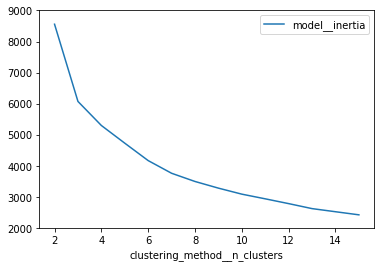

In [32]:
ax = good_results_all_features.plot.line(x='clustering_method__n_clusters', y='model__inertia')
ax.set_ylim((2000, 9000))

(2000.0, 9000.0)

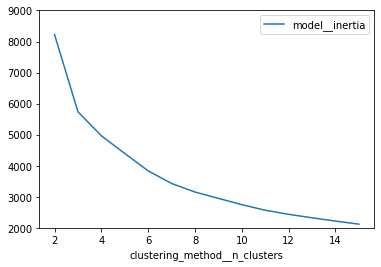

In [33]:
ax = good_results_no_bytes_based_features.plot.line(x='clustering_method__n_clusters', y='model__inertia')
ax.set_ylim((2000, 9000))

In [34]:
good_results_all_features_ideal_k = (
    good_results_all_features[good_results_all_features['clustering_method__n_clusters'] == 7].iloc[0])

display(good_results_all_features_ideal_k['cluster_counts'])
display(good_results_all_features_ideal_k['cluster_counts_per_category'])

{3: 2322, 6: 1941, 4: 1646, 1: 1637, 2: 1532, 0: 1468, 5: 1368}

{('SH', 3): 2155,
 ('SH', 6): 1617,
 ('SH', 0): 1424,
 ('SH', 1): 1372,
 ('SH', 2): 1358,
 ('SH', 4): 1335,
 ('SH', 5): 1306,
 ('NET', 6): 324,
 ('NET', 4): 311,
 ('NET', 1): 265,
 ('NET', 2): 174,
 ('NET', 3): 167,
 ('NET', 5): 62,
 ('NET', 0): 44}

In [35]:
good_results_no_bytes_based_features_ideal_k = (
    good_results_no_bytes_based_features[good_results_no_bytes_based_features['clustering_method__n_clusters'] == 7].iloc[0])

display(good_results_no_bytes_based_features_ideal_k['cluster_counts'])
display(good_results_no_bytes_based_features_ideal_k['cluster_counts_per_category'])

{1: 2310, 3: 1945, 6: 1645, 0: 1638, 4: 1549, 2: 1463, 5: 1364}

{('SH', 1): 2143,
 ('SH', 3): 1620,
 ('SH', 2): 1419,
 ('SH', 4): 1375,
 ('SH', 0): 1373,
 ('SH', 6): 1334,
 ('SH', 5): 1303,
 ('NET', 3): 325,
 ('NET', 6): 311,
 ('NET', 0): 265,
 ('NET', 4): 174,
 ('NET', 1): 167,
 ('NET', 5): 61,
 ('NET', 2): 44}

In [36]:
with open(os.path.join(DATA_DIRPATH, 'results', 'k_means_scenario_1_good_results_all_features_ideal_k.pkl'), 'wb') as f:
    pickle.dump(good_results_all_features_ideal_k.to_dict(), f)

with open(os.path.join(DATA_DIRPATH, 'results', 'k_means_scenario_1_good_results_no_bytes_based_features_ideal_k.pkl'), 'wb') as f:
    pickle.dump(good_results_no_bytes_based_features_ideal_k.to_dict(), f)

In [37]:
display(scipy.stats.spearmanr(df_results['cluster_count_entropy'], df_results['model__inertia']))
display(scipy.stats.spearmanr(df_results['model__inertia'], df_results['metric__homogeneity']))
display(scipy.stats.spearmanr(df_results['cluster_count_entropy'], df_results['metric__homogeneity']))

SpearmanrResult(correlation=0.06835383888154908, pvalue=3.956935402187096e-17)

SpearmanrResult(correlation=-0.07383748889474084, pvalue=9.815981611009924e-20)

SpearmanrResult(correlation=0.6789041372149193, pvalue=0.0)

# Exporting VNET IP addresses with cluster labels

In [38]:
df_features, df_labels = load_features_and_labels(
    os.path.join(DATA_DIRPATH, 'features', 'scenario_1.parquet'),
    os.path.join(DATA_DIRPATH, 'features', 'scenario_1_labels.parquet'),
    ip_categories)

df_features_filtered = df_features[df_features['num_flows_per_ip'] > 1].copy()
df_labels_filtered = df_labels[df_labels['ip_address'].isin(df_features_filtered.index)].reset_index(drop=True)

## Scenario 1

In [39]:
df_labels_good_results_all_features_ideal_k = df_labels_filtered[['ip_address', 'category']].copy()
df_labels_good_results_all_features_ideal_k['cluster_label'] = good_results_all_features_ideal_k['cluster_labels']
df_labels_good_results_all_features_ideal_k = df_labels_good_results_all_features_ideal_k.sort_values(by='cluster_label')
df_labels_good_results_all_features_ideal_k.to_csv(
    os.path.join(ROOT_DIRPATH, 'Sent to VNET', '2023-01-26 - Clusters of VNET IPs', 'scenario_1_all_features.csv'), index=False)

In [40]:
df_labels_good_results_no_bytes_based_features_ideal_k = df_labels_filtered[['ip_address', 'category']].copy()
df_labels_good_results_no_bytes_based_features_ideal_k['cluster_label'] = good_results_no_bytes_based_features_ideal_k['cluster_labels']
df_labels_good_results_no_bytes_based_features_ideal_k = df_labels_good_results_no_bytes_based_features_ideal_k.sort_values(by='cluster_label')
df_labels_good_results_no_bytes_based_features_ideal_k.to_csv(
    os.path.join(ROOT_DIRPATH, 'Sent to VNET', '2023-01-26 - Clusters of VNET IPs', 'scenario_1_no_bytes_based_features.csv'), index=False)

In [41]:
df_labels_good_results_all_features_ideal_k['cluster_label_no_bytes'] = df_labels_good_results_no_bytes_based_features_ideal_k['cluster_label']
df_labels_good_results_all_features_ideal_k

,ip_address,category,cluster_label,cluster_label_no_bytes
4547,192.168.185.91,SH,0,2
2057,192.168.169.6,SH,0,2
2058,192.168.193.49,SH,0,2
5029,192.168.191.231,SH,0,2
5025,192.168.191.81,SH,0,2
...,...,...,...,...
10061,100.64.21.17,SH,6,3
7221,100.64.5.12,SH,6,3
7220,100.64.23.22,SH,6,3
10056,100.64.10.11,SH,6,3


Indication of how stable the clusters are given different feature sets:

In [42]:
df_labels_good_results_all_features_ideal_k[['cluster_label', 'cluster_label_no_bytes']].value_counts()

cluster_label  cluster_label_no_bytes
3              1                         2304
6              3                         1940
4              6                         1643
1              0                         1637
2              4                         1531
0              2                         1463
5              5                         1364
3              4                           17
0              1                            5
5              3                            4
2              6                            1
3              6                            1
4              1                            1
               3                            1
               4                            1
6              0                            1
dtype: int64

In [56]:
different_cluster_labels = df_labels_good_results_all_features_ideal_k[['cluster_label', 'cluster_label_no_bytes']].value_counts().iloc[7:].index.tolist()

ips_with_different_cluster_labels = pd.concat([
    df_labels_good_results_all_features_ideal_k[
        (df_labels_good_results_all_features_ideal_k['cluster_label'] == label_all)
        & (df_labels_good_results_all_features_ideal_k['cluster_label_no_bytes'] == label_no_bytes)
    ]
    for label_all, label_no_bytes in different_cluster_labels
])

In [57]:
ips_with_different_cluster_labels

,ip_address,category,cluster_label,cluster_label_no_bytes
879,45.89.54.53,SH,3,4
1608,81.89.49.109,SH,3,4
8800,2a01:390:12:4::7,SH,3,4
8798,2a01:390:12:4::6,SH,3,4
8804,2a01:390:12:4::9,SH,3,4
8778,2a01:390:12:3::b,SH,3,4
8724,2a01:390:12:28::f,SH,3,4
8701,2a01:390:12:15::f,SH,3,4
8730,2a01:390:12:2::3,SH,3,4
8739,2a01:390:12:2::8,SH,3,4


In [58]:
ips_with_different_cluster_labels.to_csv(
    os.path.join(ROOT_DIRPATH, 'Sent to VNET', '2023-01-26 - Clusters of VNET IPs', 'scenario_1_different_cluster_labels.csv'),
    index=False)

# Takeaways

* number of clusters: 3-7 (probably closer to the higher number)
* homogeneity as a metric does not appear to be relevant (SH and NET samples are not well-separated in most clusters)
* cluster count entropy (custom metric) is useful for filtering out extreme cases (a single cluster containing almost all samples, with other clusters containing only a handful of samples), but is probably not ideal to optimize (the goal is not to create clusters of the same size)
* for now, we can assume a fixed set of hyperparameters from which clusters will be created. In the future, when anomaly detector re-training will be performed, it may be appropriate to devise an automated approach to select the most appropriate hyperperameters based on several metrics (for *k*-means, elbow method + cluster count "entropy").